# Step 1: Measurement

QASM SIMULATOR

In [3]:
# import numpy as np
# from qiskit.execute_function import execute

# from qiskit import BasicAer
# backend = BasicAer.get_backend('qasm_simulator')
# from qiskit import QuantumCircuit
# import qiskit
# from qiskit import Aer

# def Measurement(operator, quantum_circuit, shots, backend=Aer.get_backend('qasm_simulator')):
#     """
#     operator: the Pauli matrix we want to measure for the Quantum Nature Gradient Descent with writing in this from (pauli_matrix+is_position). For exammple: (Z1Z2) or (X3)
#     quantum_circuit: the circuit for measurement 
#     shots: the number of shots that we want to executee
#     !!!COMMENT: In my way of measurement, I reverse the qiskit-way of reprent a arbitrary state for more easily handle in my code, if I don't my code would be meesy and changing alot, and more I want measure the same as the we repsent them like XZZ to be X o Z o Z not be reversed like the qiskit does hmmmmmmmmmmmm
#     """


#     number_of_qubits = quantum_circuit.num_qubits

#     cr = qiskit.ClassicalRegister(number_of_qubits)

    
#     if len(operator) > (number_of_qubits):
#         raise Exception("The position of Pauli matrix exceeds the number of qubits")


#     quantum_circuit_to_measurement = QuantumCircuit(number_of_qubits)


#     expectation_value = 0

#     for i in range(len(operator)):
#         if operator[i] == 'X':
#             quantum_circuit_to_measurement.ry(-np.pi/2, i)
#         if operator[i] == 'Y':
#             quantum_circuit_to_measurement.rx(np.pi/2, i)

#     new_quantum_circuit_to_measurement = quantum_circuit.compose(quantum_circuit_to_measurement)

#     # new_quantum_circuit_to_measurement.add_register(cr)

#     # if operator.count('I') == number_of_qubits:
#     #     return 1
#     # else:
#     #     for i in range(len(operator)):
#     #         if operator[i] != 'I':
#     #             new_quantum_circuit_to_measurement.measure(i,i)
                

#     new_quantum_circuit_to_measurement.measure_all()


#     job = execute(new_quantum_circuit_to_measurement, backend, shots=shots)

#     result = job.result()

#     counts = result.get_counts()

#     # Reversed the way qiskit represnts state
#     counts_change =  {(key)[::-1] : value for key, value in counts.items()}

    

#     # for i in range(len(counts)):
#     #     if list(counts.keys())[i].count('1') % 2 == 0:
#     #         expectation_value += counts[list(counts.keys())[i]]
#     #     if list(counts.keys())[i].count('1') % 2 != 0:
#     #         expectation_value -= counts[list(counts.keys())[i]]

#     position_of_non_I_gate = np.where(np.array(list(operator)) != 'I')[0]
#     # expectation_value = 0

#     for i in range(len(counts_change)):
#         extra_minus = 1
#         for j in range(len(position_of_non_I_gate)):
#             if list(counts_change.keys())[i][position_of_non_I_gate[j]] == '1':
#                 extra_minus *= -1
    
#     # print(f'{list(counts.keys())[i]} ooo  {extra_minus}')

       
#         expectation_value += counts_change[list(counts_change.keys())[i]]*extra_minus
        

#     expectation_value = expectation_value/shots

#     return expectation_value, counts_change, new_quantum_circuit_to_measurement

In [18]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,2)
qc.x(1)
qc.draw('mpl', style='iqx')
print(Measurement("YIY", qc, 20000)[0])
print(Measurement("ZIZ", qc, 20000)[0])
print(Measurement("IIX", qc, 20000)[0])

-1.0000000000000002
1.0000000000000002
0.0


STATEVECTOR SIMULATOR

In [131]:
import numpy as np
from qiskit.execute_function import execute
from qiskit import Aer

from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
from qiskit import QuantumCircuit
import qiskit
from qiskit.quantum_info import Pauli


def Measurement(operator, quantum_circuit, shots, backend=Aer.get_backend('statevector_simulator')):
    """
    operator: the Pauli matrix we want to measure for the Quantum Nature Gradient Descent with writing in this from (pauli_matrix+is_position). For exammple: (Z1Z2) or (X3)
    quantum_circuit: the circuit for measurement 
    shots: the number of shots that we want to executee
    !!!COMMENT: In my way of measurement, I reverse the qiskit-way of reprent a arbitrary state for more easily handle in my code, if I don't my code would be meesy and changing alot, and more I want measure the same as the we repsent them like XZZ to be X o Z o Z not be reversed like the qiskit does hmmmmmmmmmmmm
    """


    number_of_qubits = quantum_circuit.num_qubits

    cr = qiskit.ClassicalRegister(number_of_qubits)

    
    if len(operator) > (number_of_qubits):
        raise Exception("The position of Pauli matrix exceeds the number of qubits")

    expectation_value = 0

    operator = operator[::-1]

    job = backend.run(quantum_circuit)

    vector = np.matrix(job.result().get_statevector())

    vector_dagger = np.transpose(vector.H)
    vector_normal = np.transpose(vector)
    
    expectation_value = np.array((vector_dagger.dot(Pauli(operator).to_matrix())).dot(vector_normal))[0][0].real

    return expectation_value, vector_normal

In [165]:
qc = QuantumCircuit(3)
qc.ry(np.pi/6 ,0)
qc.ry(np.pi/3 ,1)
qc.ry(np.pi/3 ,2)
qc.cx(0,2)
qc.cx(0,1)
qc.x(1)
qc.draw('mpl', style='iqx')
print(Measurement("YIY", qc, 20000)[0])
print(Measurement("ZIZ", qc, 20000)[0])
print(Measurement("IIX", qc, 20000)[0])

-0.2165063509461097
0.5000000000000002
0.8660254037844386


# Step 2: Ansatz construction

In [19]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

def Customize_EfficientSU2(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        theta1 = Parameter(r'$\theta[{}]$'.format(0))
        circuit.ry(theta1, 0)
        theta2 = Parameter(r'$\theta[{}]$'.format(1))
        circuit.rz(theta2, 0)
        circuit.barrier()

        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(2*i+2))
            circuit.ry(theta1, 0)
            theta2 = Parameter(r'$\theta[{}]$'.format(2*i+3))
            circuit.rz(theta2, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        # sub_circuit.cx(number_qubits-1, 0)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_qubits+number_parameter+i))
            sub_circuit.rz(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
        circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit


def Customize_RealAmplidues(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:

        for i in range(0, number_qubits):
                theta = Parameter(r'$\theta[{}]$'.format(i))
                circuit.ry(theta, i)
                circuit.barrier()
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(1+i))
            circuit.ry(theta1, 0)
            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    # for i in range(0, number_qubits):
    #     theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
    #     circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit

# Step 3: Create the Customize Finite Difference, Parameter Shift Rule and Quantum Natural Gradient Descent

In [134]:
import numpy as np
from scipy.linalg import block_diag

# Parameter shift rule
def Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += np.pi/2
            minus_parameter = parameter.copy()
            minus_parameter[j] -= np.pi/2
            grad_func[j] = (eta)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/2
        grad = np.add(grad, grad_func)
    
    return np.array(grad)


# Gradient
def Customize_Finite_Difference(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    h = 1e-3 # 0.05

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += h
            minus_parameter = parameter.copy()
            minus_parameter[j] -= h
            grad_func[j] = (eta)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i,
            theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*h)
        grad = np.add(grad, grad_func)
    
    return np.array(grad)

def Seperate_Circuit_Apart(ansantz):
    # Divide the circuit to subcircuit of parameter circuit and non parameter circuit
    super_circuit = []
    no_name = 0

    ansatz_barrier = 0 

    for i in range(len(ansatz)):
        if ansatz[i].operation.name == 'barrier':
            ansatz_barrier += 1


    while no_name < (ansatz.size() + ansatz_barrier):
        if ansatz[no_name].operation.params:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(no_name, ansatz.num_qubits + no_name):
                sub_circuit.append(ansatz[i])
            super_circuit.append(sub_circuit)
            no_name += ansatz.num_qubits 
            
        elif ansatz[no_name].operation.name == 'barrier':
            no_name += 1
            
        else:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            
            while not ansatz[no_name].operation.params:
                if ansatz[no_name].operation.name == 'barrier':
                    no_name += 1
                    break
                sub_circuit.append(ansatz[no_name])
                no_name += 1 

                if no_name == (ansatz.size() + ansatz_barrier - 1):
                    break

            super_circuit.append(sub_circuit)
    return super_circuit




def Customize_Quantum_Natural_Graident_Descent(operator, parameter, eta, ansatz, shots, backend, interation, super_circuit):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """

    number_of_parameters = ansatz.num_parameters

    # return parameter_shift_rules(operator, parameter, ansatz)

    # Next, I will calculate the Fubini-Study metric, but first I would like to learn the way of extracting information from the ansatz, and calculate the Fubini-Study metric
    def fubini_stydy_metric(ansatz, parameter, shots, backend):
        def Measure_element_of_Fubini_Study_metric(circuit, circuit_for_measurement, i, j, shots, backend):
            if i != j:
                term1 = ['I']*len(circuit)
                term2 = ['I']*len(circuit)
                term3 = ['I']*len(circuit)
                
                # Change rotation gate to pauli gate
                # Term1
                if circuit[i].operation.name == 'rx':
                    term1[i] = 'X'
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term1[i] = 'Y'
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term1[i] = 'Z'
                    term2[i] = 'Z'
                
                if circuit[j].operation.name == 'rx':
                    term1[j] = 'X'
                    term3[j] = 'X'
                if circuit[j].operation.name == 'ry':
                    term1[j] = 'Y'
                    term3[j] = 'Y'
                if circuit[j].operation.name == 'rz':
                    term1[j] = 'Z'
                    term3[j] = 'Z'

                # # Term 2
                # if circuit[i].operation.name == 'rx':
                #     term2[i] = 'X'
                # if circuit[i].operation.name == 'ry':
                #     term2[i] = 'Y'
                # if circuit[i].operation.name == 'rz':
                #     term2[i] = 'Z'

                # # Term 3
                # if circuit[j].operation.name == 'rx':
                #     term3[j] = 'X'
                # if circuit[j].operation.name == 'ry':
                #     term3[j] = 'Y'
                # if circuit[j].operation.name == 'rz':
                #     term3[j] = 'Z'
                

                term1 = ''.join(term1)
                term2 = ''.join(term2)
                term3 = ''.join(term3)

                return  ((Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4).real
            else:
                term2 = ['I']*len(circuit)

                if circuit[i].operation.name == 'rx':
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term2[i] = 'Z'

                term2 = ''.join(term2)


                return ((1 - Measurement(term2, circuit_for_measurement, shots, backend)[0]**2)/4).real


        # Caculate the Fubini-Study metric in 1-qubit
        if ansatz.num_qubits == 1:
            initial_point = parameter.copy()
            # num_parameter = 0
            g = np.zeros((number_of_parameters, number_of_parameters))

            for i in range(len(super_circuit)):
                if super_circuit[i][0].operation.params:
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for j in range(i):
                        internal_circuit = internal_circuit.compose(super_circuit[j])

                    internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                    # num_parameter += super_circuit[i].num_parameters

                    g[i][i] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, 0, 0, shots, backend)
                    # print(np.round(g_internal,2))
            return g

        
        # Caculate the Fubini_study_metric
        g = []
        initial_point = parameter.copy()
        # num_parameter = 0


        for i in range(len(super_circuit)):
            if super_circuit[i][0].operation.params:
                g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]
                internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                for j in range(i):
                    internal_circuit = internal_circuit.compose(super_circuit[j])

                internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                # num_parameter += super_circuit[i].num_parameters

                # print(num_parameter)
                
                for l in range(super_circuit[i].num_parameters):
                    for m in range(l, super_circuit[i].num_parameters):
                        if l != m:
                            g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, m, shots, backend)
                            g_internal[m][l] = g_internal[l][m]
                        else:
                            g_internal[l][l] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, l, shots, backend)
                if g != []:
                    g = block_diag(g, g_internal)
                else:
                    g = block_diag(g_internal)
        print(f'{g}')
        return g
    

    # Gradient of the loss function
    grad = np.zeros(len(parameter))
    
    grad = Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation)

    
    # grad = gradient(operator, parameter, ansatz)

    # Inverse of Fubini study metric
    FS_metric = np.linalg.pinv(fubini_stydy_metric(ansatz, parameter, shots, backend).real)
    # print(fubini_stydy_metric(ansatz, parameter, shots, backend))

    # print(FS_metric)

    combine = FS_metric.dot(grad)

    # print(f'Fubini-Study metric: {FS_metric}')

    # print(f'combine: {combine}')
    return combine

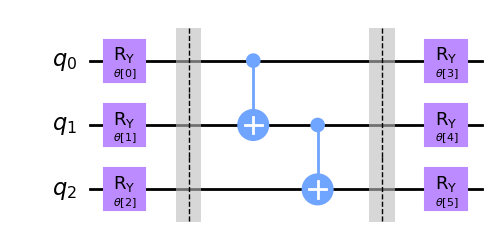

In [166]:
qc = Customize_RealAmplidues(3,1)
qc.draw('mpl')

Customize SPSA

In [ ]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  

    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

def Customize_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    delTheta = 0.05
    
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    a = delTheta*((A+1)**alpha)/magnitude_g0
    
    internal_initial_point = initial_point.copy()

    energy = []

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_initial_point)
        print(internal_energy)
        energy.append(internal_energy)


        # Optimization part
        grad = np.zeros(ansatz.num_parameters)
        # ak = a/(1+k+A)**alpha
        # ck = c/(1+k)**gamma
        ak = 0.01
        ck = 1
        
        # print(f'ak_{k}: {ak}')
        # print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            # random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            random = np.array([1 for _ in range(ansatz.num_parameters)])
            # print(random)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = ak*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            grad = np.add(grad, grad_func*random)
        # print(f'grad: {grad}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy


Customize QN-SPSA

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer, execute

def SwapTest(circ1, circ2, shots, backend):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    result = execute(circ, backend, shots=shots).result()

    counts = result.get_counts()

    overlap_value = 0

    if '1' in counts:
        # Key exists, do something with data['value']
        overlap_value = counts['1']
    else:
        # Key doesn't exist, return to default value (0 in this case)
        overlap_value = 0
    
    overlap_value = 1 - 2*overlap_value/shots

    

    
    return overlap_value, circ

def Customize_QN_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # # Scaling parameter for the gradient step size.
    # c = 1

    # # Stability constant for the step size 10% of number of interations
    # A = 0.1*interation

    # # Scaling exponent for the step size
    # alpha = 0.602

    # # Scaling exponent for the gradient step size
    # gamma = 0.101

    # #  Smallest change of magnitude desired in the elements of θ.
    # # delTheta = 0.001
    # delTheta = 0.05
    
    
    # magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    # a = delTheta*((A+1)**alpha)/magnitude_g0
    # a = 0.001

    #  regularization coefficient
    beta = 0.001
    
    internal_initial_point = initial_point.copy()

    energy = []

    regularized_fubini_matrix_previous = np.zeros((ansatz.num_parameters, ansatz.num_parameters))

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_energy)
        print(internal_initial_point)
        energy.append(internal_energy)

        grad = np.zeros(ansatz.num_parameters)
        # SPSA part
        gradSPSA = np.zeros(ansatz.num_parameters)
        # ak = a/(1+k+A)**alpha
        # ck = c/(1+k)**gamma
        ck = 0.01
        ak = 0.01
        
        # print(f'ak_{k}: {ak}')
        # print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            # random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            random = np.array([-1.0 for _ in range(ansatz.num_parameters)])
            print(random*ck)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            # ? grad SPSA 
            gradSPSA = np.add(gradSPSA, grad_func*random)
        
        # print(f'gradSPSA {gradSPSA}')

        
        # Natural Gradient Part
        # random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        # random2 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        random1 = np.array([1.0 for _ in range(ansatz.num_parameters)])
        random2 = np.array([-1.0 for _ in range(ansatz.num_parameters)])
        initial_plus1_plus2 = np.add(initial_point, np.add(ck*random1, ck*random2))
        initial_plus1 = np.add(initial_point, ck*random1)
        initial_minus1_plus2 = np.subtract(initial_point, np.subtract(ck*random1, ck*random2))
        initial_minus1 = np.subtract(initial_point, ck*random1)

        ansatz_initial = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1_plus2 = ansatz.bind_parameters({theta: initial_plus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1 = ansatz.bind_parameters({theta: initial_plus1[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1_plus2 = ansatz.bind_parameters({theta: initial_minus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1 =  ansatz.bind_parameters({theta: initial_minus1[k] for k, theta in enumerate(ansatz.parameters)})  

        deltaF = SwapTest(ansatz_initial, ansatz_plus1_plus2, shots, backend)[0] - SwapTest(ansatz_initial, ansatz_plus1, shots, backend)[0] -SwapTest(ansatz_initial, ansatz_minus1_plus2, shots, backend)[0] + SwapTest(ansatz_initial, ansatz_minus1, shots, backend)[0]

        # Fubini_matrix
        fubini_matrix = -1/2*(deltaF/(2*ck**2))*(np.array(np.array([random1]).T*random2) + np.array(np.array([random2]).T*random1))/2
        
        print(f"fubini_matrix: {fubini_matrix}")
        # Data of previous regularized study metric
        exponentially_smoothed_fubini = k/(k+1)*regularized_fubini_matrix_previous + 1/(k+1)*fubini_matrix.copy()

    
        regularized_fubini_matrix = np.add(np.power(exponentially_smoothed_fubini*exponentially_smoothed_fubini, 1/2), beta*np.identity(ansatz.num_parameters))

        regularized_fubini_matrix_previous = regularized_fubini_matrix

        print(regularized_fubini_matrix)

        # print(f'regularized_fubini_matrix---{regularized_fubini_matrix}')

        grad = ak*np.linalg.pinv(regularized_fubini_matrix).dot(gradSPSA)

        # print(f'grad: {grad/ak}')
        # print(f'parameter {internal_initial_point}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy

# Step 4: Variational Quantum Eigensolver

In [21]:
def Customize_Variational_Quantum_EigenSolver(operator, optimize, interation, ansatz, eta, initial_point, shots, backend, callback):
    """
    operator: the pauli matrix
    interation: number of interations 
    ansatz: the ansatz for perparing the parameterized circuit
    eta: learning rate
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """

    energy = []

    internal_initial_point = initial_point.copy()
    
    b = np.zeros(ansatz.num_parameters)
    
    super_circuit = Seperate_Circuit_Apart(ansatz)

    for i in range(interation):
        print(f'{internal_initial_point} ---------')
        internal_ansatz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})       
        # Measure the expectation of our hamiltonian
        internal_energy = 0
        for j in range(len(operator)):
            # print(str(operator.primitive._pauli_list[j]))
            # print(operator.coeffs.real[j])
            internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_ansatz, shots, backend)[0]
            # print( operator.coeffs.real[j])
            # print(operator.primitive._pauli_list[j])
            # print(internal_energy)
            
            # measure = Measurement('X', internal_anstaz, 10000, backend=Aer.get_backend('qasm_simulator'))[0]*10
            # print(f'///{measure}///')
        
        # print(f'{internal_initial_point} hmm')
        
        energy.append(internal_energy)
        print(internal_energy)


        if callback is not None:
            callback(internal_initial_point, internal_energy)

        # Update the parameter points
        if optimize == Customize_Quantum_Natural_Graident_Descent:
            a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, super_circuit)
            # b = a.copy()
            internal_initial_point =  np.subtract(internal_initial_point,a)
            # print(internal_energy)

            continue

        a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation)
        # a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation), -0.9*b)
        # b = a.copy()
        internal_initial_point =  np.subtract(internal_initial_point,a)
        # print(f'a: {a}')

        # print(internal_energy)

    if callback is None:
        return energy



# Step 5: The Ising model

In [34]:
from qiskit.opflow import Z, I, X, Y

# Ising hamiltonian
def Ising_hamiltonian(num_qubits, J, h):
    hamiltonian = 0

    if num_qubits == 1:
        hamiltonian = -J*Z - h*X
        return hamiltonian.reduce()

    if num_qubits == 2:
        hamiltonian = -J*Z^Z
        hamiltonian -= h*X^I
        hamiltonian -= h*I^X
        return hamiltonian.reduce()


    
    # hamiltonian += -J*Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (-J)*((I^(i))^(Z^Z)^(I^(num_qubits-2-i)))
    
    for i in range(num_qubits):
        hamiltonian -= h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()

In [133]:
print(Ising_hamiltonian(3, -1, -1))

1.0 * ZZI
+ 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX


In [141]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyEigensolver

exact_solver = NumPyEigensolver(k=100)
hamiltonian = Ising_hamiltonian(3, -1, -1)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(hamiltonian)
print(exact_result.eigenvalues.real)

1.0 * ZZI
+ 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX
[-3.49395921 -2.60387547 -1.         -0.10991626  0.10991626  1.
  2.60387547  3.49395921]


# Step 6: Test VQE

In [38]:
print(Ising_hamiltonian(3, J, h))

1.0 * ZZI
+ 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX


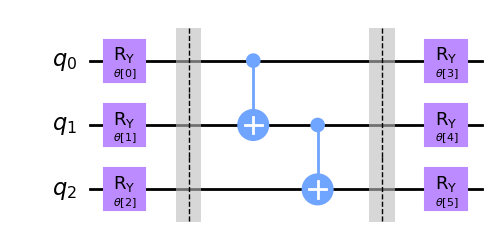

In [136]:
ansatz = Customize_RealAmplidues(num_qubits, reps)
ansatz.draw('mpl')

In [139]:
ansatz.

AttributeError: 'QuantumCircuit' object has no attribute 'func_name'

In [237]:
from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

start_time = time.time()

num_qubits =  3 # (N_p = num_qubit-1)
reps = 1
J = -1
h = -1


intermediate_info = {
    'parameters': [],
    'energy': [],
}

def callback(parameters, energy):
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)


# ansatz = Customize_EfficientSU2(num_qubits, 1)

hamiltonian = Ising_hamiltonian(num_qubits, J, h)
ansatz = Customize_RealAmplidues(num_qubits, reps)
# ansatz = Customize_EfficientSU2(num_qubits, reps)

interation = 1

initial_point = np.zeros(ansatz.num_parameters)+0.5


eta = 0.01
shots = 20000

from qiskit import Aer

backend = Aer.get_backend('statevector_simulator')

# optimize = Customize_Finite_Difference
# optimize = Customize_Parameter_Shift_Rule
# optimize = Customize_Parameter_Shift_Rule
# optimize = 'SPSA'

# energy = Customize_Variational_Quantum_EigenSolver(hamiltonian, optimize, interation, ansatz, eta, initial_point, shots, backend, callback=callback)
# energy = Customize_SPSA(hamiltonian, interation, ansatz, initial_point, shots, backend, callback=callback)
energy = Customize_QN_SPSA(hamiltonian, interation, ansatz, initial_point, shots, backend, callback)

# file_name = f'{str(optimize.__name__)} - LR {eta} - shots {shots} - interation {interation} - RealAmplitude({num_qubits},{reps}) - J{J}h{h}'

# file = open(f'D:/Book store/Learning document/QC/Buidng VQE and VQD from scratch/Variational-Quantum-EigeinSolver/Crosscheck/{file_name}.txt', 'w')

# file.write('Parameters: \n')
# file.write(str(intermediate_info['parameters']))

# for i in range(3):
#     file.write('\n')

# file.write('Energy: \n')
# file.write(str(intermediate_info['energy']))

# file.close()


3.2127067231600352
[0.5 0.5 0.5 0.5 0.5 0.5]
[-0.01 -0.01 -0.01 -0.01 -0.01 -0.01]
[-0.01 -0.01 -0.01 -0.01 -0.01 -0.01]
[-0.01 -0.01 -0.01 -0.01 -0.01 -0.01]
[-0.01 -0.01 -0.01 -0.01 -0.01 -0.01]
[-0.01 -0.01 -0.01 -0.01 -0.01 -0.01]
fubini_matrix: [[2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2.]]
[[2.001 2.    2.    2.    2.    2.   ]
 [2.    2.001 2.    2.    2.    2.   ]
 [2.    2.    2.001 2.    2.    2.   ]
 [2.    2.    2.    2.001 2.    2.   ]
 [2.    2.    2.    2.    2.001 2.   ]
 [2.    2.    2.    2.    2.    2.001]]


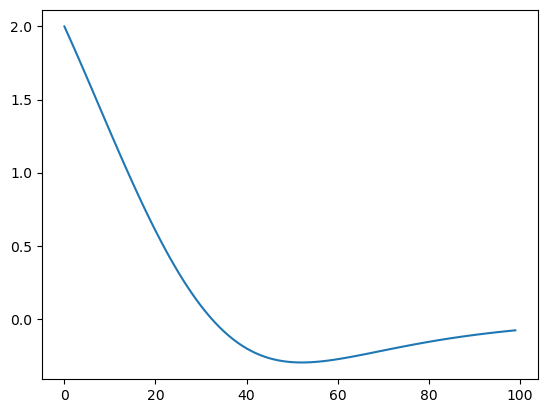

In [184]:
plt.plot(energy)

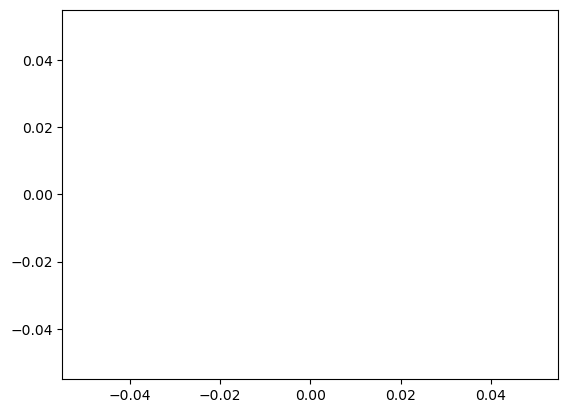

In [179]:
plt.plot(intermediate_info['energy'])

# RealApmplitude

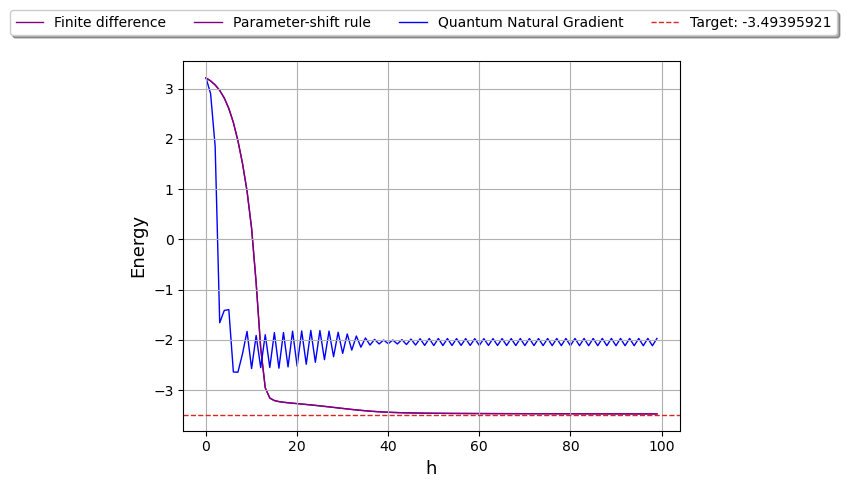

In [163]:
import matplotlib
import matplotlib.pyplot as plt

gs_energy = -3.49395921 

fig, ax = plt.subplots()

QNG = np.array([3.2127067231600352, 2.898795613370617, 1.8515615584833012, -1.6601322538426764, -1.4158333961498748, -1.3985865992328486, -2.6405679030018003, -2.644515029638251, -2.2794183893206075, -1.8323896752871192, -2.572135395348642, -1.9135144710106526, -2.5537424950707486, -1.8985666020681398, -2.5515687857390232, -1.8574853693636115, -2.5646335656545, -1.854070535282232, -2.538885554306561, -1.828161204560869, -2.524543474866837, -1.8232981966673378, -2.486124894198471, -1.8133735962733397, -2.4472696244684684, -1.8161489523853436, -2.3946913109536823, -1.8264796233830838, -2.3357140181217875, -1.8493842360974322, -2.2703061478117577, -1.8834522821413513, -2.204743471591294, -1.9244367494068686, -2.146972935450969, -1.9636740419715242, -2.104954987238548, -1.9920350445476775, -2.0823025495394436, -2.0049083771270206, -2.0768929337348396, -2.004251866706079, -2.0828685893729824, -1.996008265807219, -2.0936096660530357, -1.9861898816178267, -2.1038473837848817, -1.9786091637887047, -2.110715135806009, -1.9745401395556628, -2.1137293623093782, -1.973492632212994, -2.113923856697103, -1.974233056999035, -2.1127867260330078, -1.9755421004954457, -2.111534037242558, -1.976595055648235, -2.1108348021877545, -1.977040220655853, -2.1108523556947985, -1.9768940976780967, -2.1114287498937925, -1.9763668376848895, -2.112284955869015, -1.9757040970217088, -2.1131672544272044, -1.9750898401413444, -2.1139183163106665, -1.9746145363581866, -2.1144843999568588, -1.9742889024282553, -2.114885493982574, -1.9740772355081737, -2.1151752797353147, -1.973930164380521, -2.115408796297496, -1.973806457163543, -2.1156247729878466, -1.9736820036918585, -2.1158414796111673, -1.9735491083327563, -2.1160610793350907, -1.9734108640370527, -2.1162770852628174, -1.973274721300678, -2.116481064739661, -1.9731476978721494, -2.1166667890017443, -1.9730340002256965, -2.116831692652861, -1.9729346886877106, -2.1169764363758983, -1.9728485327310012, -2.11710360451593, -1.9727732213873814, -2.1172163633562717, -1.9727063724834841, -2.11731753077237, -1.9726461106603432])
FD = np.array([3.2127067231600352, 3.153186150220005, 3.073276398364362, 2.963972040260551, 2.812979571705336, 2.605149097747571, 2.325110166373665, 1.9623487089660552, 1.5129332310258208, 0.9601294335132252, 0.2200039501447968, -0.8644790097980969, -2.1656550413317777, -2.956100537875554, -3.1595768472711647, -3.208958567764548, -3.2297472102414435, -3.2426689740975343, -3.25275010990494, -3.261668426912107, -3.270148095945906, -3.2785655458792142, -3.287135035737283, -3.2959790319341096, -3.305159812198876, -3.314694759108243, -3.3245638526818144, -3.334713619355528, -3.3450601447264523, -3.355492887104128, -3.3658803697649313, -3.37607817092206, -3.385938926847654, -3.395323391111923, -3.4041111061485956, -3.4122091027399217, -3.4195573259771566, -3.426130126862426, -3.431933956800003, -3.4370021046781867, -3.441387725842884, -3.4451564615520116, -3.448379701854354, -3.451129146320315, -3.4534729113140137, -3.455473117835571, -3.457184707103258, -3.458655160848119, -3.459924814816333, -3.4610275090361196, -3.461991387119796, -3.4628397209368056, -3.463591688091767, -3.46426306609603, -3.4648668307373964, -3.465413659990813, -3.465912351918111, -3.466370167864721, -3.466793112672842, -3.467186162784861, -3.4675534517352484, -3.4678984210337727, -3.468223943034894, -3.468532421155734, -3.4688258717697997, -3.4691059912559137, -3.469374210997227, -3.4696317425772767, -3.469879614982726, -3.470118705274056, -3.4703497639069147, -3.470573435664577, -3.4707902769830685, -3.4710007703066936, -3.4712053359956885, -3.4714043422132788, -3.4715981131432274, -3.471786935826395, -3.4719710658539005, -3.472150732112966, -3.472326140747162, -3.4724974784647045, -3.4726649153054594, -3.472828606958103, -3.472988696703347, -3.473145317045987, -3.4732985910879868, -3.4734486336858152, -3.473595552427961, -3.4737394484624735, -3.47388041719935, -3.4740185489082758, -3.4741539292290122, -3.4742866396085574, -3.47441675767703, -3.4745443575721238, -3.4746695102203797, -3.4747922835820875, -3.474912742865613, -3.4750309507158446])
PRS = np.array([3.2127067231600352, 3.15318613959942, 3.0732763697142733, 2.9639719813579553, 2.8129794634762675, 2.605148913161429, 2.3251098727687465, 1.9623482749223995, 1.5129326262116496, 0.9601285833358386, 0.22000262758605738, -0.8644810725692993, -2.165657121192886, -2.956101354071607, -3.159577039912137, -3.2089586407349238, -3.2297472527206956, -3.2426690060020906, -3.252750137682661, -3.261668453318641, -3.270148122472596, -3.278565573466353, -3.287135065023333, -3.2959790633583923, -3.305159846045572, -3.3146947955212367, -3.324563891664121, -3.334713660762136, -3.3450601882584055, -3.355492932310132, -3.365880416055763, -3.3760782176006012, -3.3859389731537903, -3.395323436278333, -3.404111149459782, -3.41220914358556, -3.419557363891708, -3.4261301615455086, -3.4319339881167337, -3.437002132642275, -3.441387750587947, -3.4451564832978727, -3.448379720873721, -3.4511291629099623, -3.453472925772386, -3.4554731304472917, -3.457184718129687, -3.458655170522687, -3.459924823343366, -3.4610275165919013, -3.461991393854845, -3.4628397269787143, -3.4635916935482296, -3.464263071057654, -3.4648668352803385, -3.4654136641790276, -3.465912355805314, -3.4663701714960373, -3.4667931160862073, -3.4671861660121808, -3.4675534548033813, -3.467898423965337, -3.4682239458489508, -3.46853242386834, -3.4688258743944975, -3.469105993804131, -3.469374213478602, -3.469631744999938, -3.4698796173535493, -3.4701187075988322, -3.470349766190538, -3.470573437911185, -3.4707902791961547, -3.4710007724892202, -3.471205338150148, -3.4714043443417895, -3.4715981152475903, -3.471786937908131, -3.4719710679143043, -3.472150734153149, -3.472326142768064, -3.472497480467136, -3.4726649172901087, -3.4728286089255813, -3.4729886986541723, -3.473145318980616, -3.4732985930068203, -3.473448635589204, -3.473595554316219, -3.4737394503358887, -3.4738804190581734, -3.474018550752744, -3.4741539310593392, -3.474286641424942, -3.4744167594796584, -3.474544359361178, -3.4746695119960167, -3.4747922853444715, -3.474912744614897, -3.475030952452174])

# Diagonal and VQE 3 qubit
ax.plot(FD , color='purple', alpha=1, lw=1, label='Finite difference', zorder=1)
ax.plot(PRS , color='purple', alpha=1, lw=1, label='Parameter-shift rule', zorder=1)
ax.plot(QNG , color='blue', alpha=1, lw=1, label='Quantum Natural Gradient', zorder=1)

plt.ylabel('Energy', fontsize=13)
plt.xlabel('h',  fontsize=13)
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
fig.legend(loc='upper center' ,bbox_to_anchor=(0.5, 1.001),  ncol=4, fancybox=True, shadow=True, fontsize=10)
# plt.legend(fontsize=12)
# plt.show()
ax.grid()


fig.savefig('D:/Book store/Learning document/QC/Buidng VQE and VQD from scratch/Variational-Quantum-EigeinSolver/Crosscheck/Compared_method_in_RealAmplitudes.png', format='png', dpi=500, bbox_inches='tight')

In [59]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
    
    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

# initial_point = np.array([ 0.64600354, -0.85128018, -1.04730893, -1.07769523, -2.47758958, -0.30493529])
initial_point = np.array([-0.49395506, -0.53044856, -0.43088709, -1.50952584, -1.76176268, -1.1278869 ])

print(pauli_measurement(hamiltonian, ansatz, initial_point = initial_point, shots=20000, backend = backend))

-2.7254542244620703


In [63]:
for j in range(len(hamiltonian)):
    print(hamiltonian.coeffs.real[j])
    print(str(hamiltonian.primitive._pauli_list[j]))

1.0
ZZI
1.0
IZZ
1.0
XII
1.0
IXI
1.0
IIX


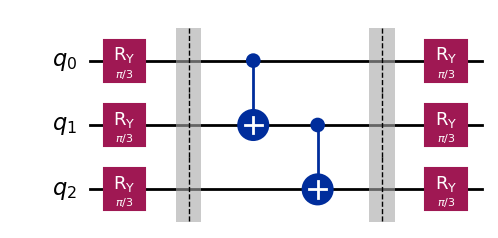

In [125]:
ansatz = Customize_RealAmplidues(3, 1)
# ansatz.cx(0, 1)
# ansatz.cx(0, 2)
# ansatz.ry(np.pi/3, 0)
# ansatz.ry(np.pi/3, 1)
# ansatz.ry(np.pi/3, 2)
initial_point = np.ones(ansatz.num_parameters) * np.pi/3
internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
internal_anstaz.draw('mpl', style='iqx')

In [103]:
backend = Aer.get_backend('statevector_simulator')
job = backend.run(internal_anstaz)
vector = np.matrix(job.result().get_statevector())
print(vector)

[[0.22712341+0.j 0.25612976+0.j 0.13112976+0.j 0.14787659+0.j
  0.31414247+0.j 0.14787659+0.j 0.36438294+0.j 0.76838929+0.j]]


In [126]:
print(Measurement("XII", internal_anstaz, 20000)[0])

0.8080127018922196


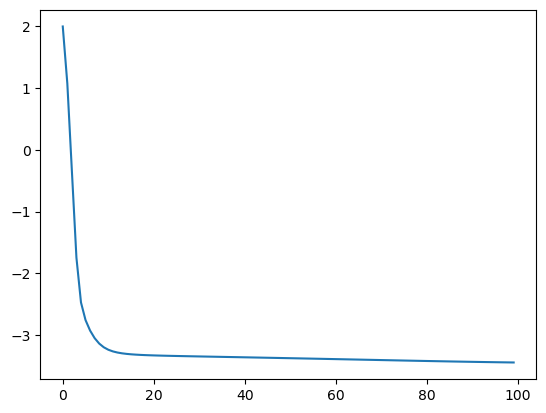

In [41]:
import matplotlib.pyplot as plt
plt.plot(intermediate_info['energy'])

[1 1 1 1 1 1]


In [239]:
def SwapTest(circ1, circ2, shots, backend):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    result = execute(circ, backend, shots=shots).result()

    counts = result.get_counts()

    overlap_value = 0

    if '1' in counts:
        # Key exists, do something with data['value']
        overlap_value = counts['1']
    else:
        # Key doesn't exist, return to default value (0 in this case)
        overlap_value = 0
    
    overlap_value = 1 - 2*overlap_value/shots

In [240]:
qc = QuantumCircuit(3)
circ1 = qc
circ2 = qc.x(1)
# SwapTest(circ1, circ2, shots, backend)
circ1.draw('mpl')

AttributeError: 'InstructionSet' object has no attribute 'draw'